In [9]:
using DrWatson
@quickactivate :NARMAXExperiments

In [14]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using LinearAlgebra
using Random
using FFTW
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames
using Plots
default(grid=false, size=(900,300), label="", margin=10Plots.pt)

In [15]:
import ReactiveMP.messageout

## Generate signal

In [257]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

full_order = delay_e + delay_y + delay_u + 1
Y = zeros(full_order, delay_y); Y[1:delay_y, 1:delay_y] = diageye(delay_y);
U = zeros(full_order, order_u); U[delay_y+1:delay_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, delay_e); H[full_order-delay_e+1:full_order, delay_e-delay_e+1:delay_e] = diageye(delay_e);

poly_order = 1

options = Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false)
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, scale_coef=0.2, w_true=2e4);

In [258]:
H

10×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

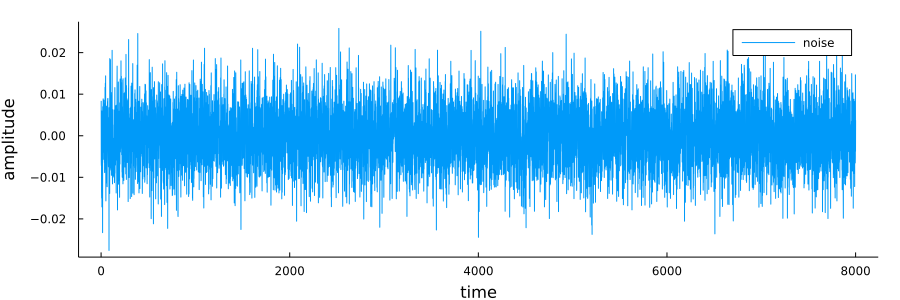

In [243]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

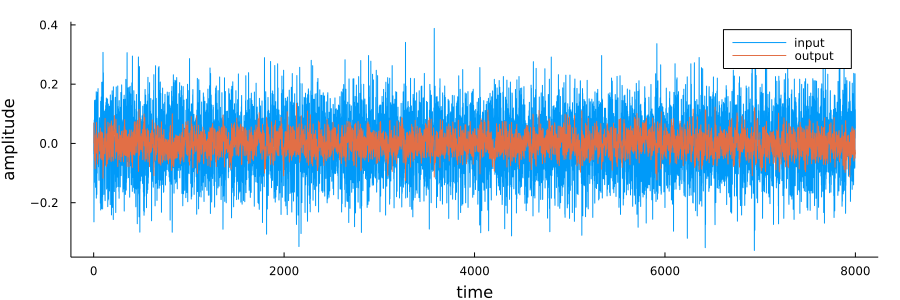

In [244]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [245]:
train_size = 1000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

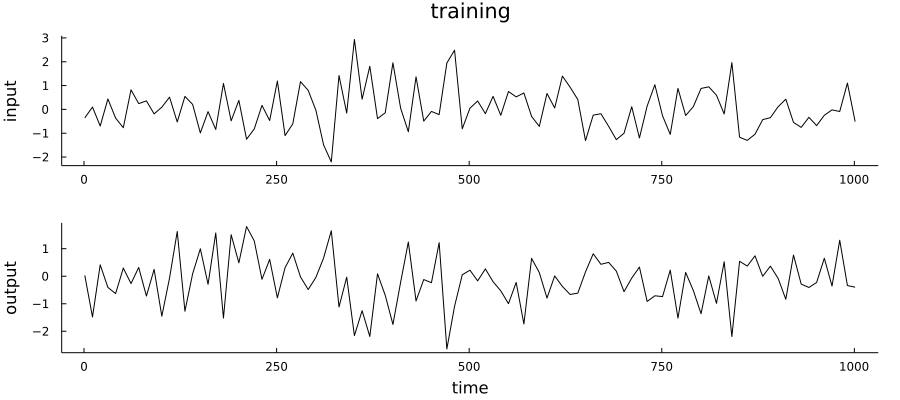

In [246]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

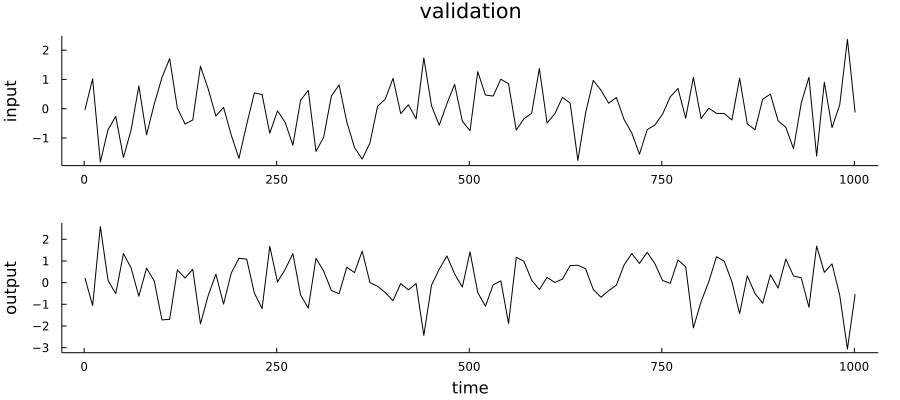

In [247]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

## Model

In [248]:
# Nonlinear MAX model definition
@model function armax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, delay_y, delay_u, delay_e)
    
    order = delay_y + delay_u + delay_e + 1
    
    S = shift(delay_e); c = zeros(delay_e); c[1] = 1.0;
    
    # initialize variables
    θ       = randomvar()
    w       = randomvar()
    h       = randomvar(n-1)
    e       = randomvar(n)
    uh      = randomvar(n)
    yuh     = randomvar(n)
    yuh_     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    Ys = [Y*y_prev[t] for t in 1:n]
    Us = [U*u[t] for t in 1:n]
        
    # priors
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    # initial
    h_0    ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    uh[1]   ~ H*h_0 + Us[1]
    yuh[1]  ~ uh[1] + Ys[1]
    yuh_[1] ~ AR(yuh[1], η, τ)
    
    b = zeros(order); b[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t] ~ NormalMeanPrecision(0.0, w)
        h[t] ~ S*h_prev + c*e[t]
        y[t]    ~ dot(yuh_[t], b) + e[t]
    
        h_prev = h[t]
        uh[t+1]   ~ H*h_prev + Us[t+1]
        yuh[t+1]  ~ uh[t+1] + Ys[t+1]
        yuh_[t+1] ~ AR(yuh[t+1], η, τ)
    end
    
    e[n] ~ NormalMeanPrecision(0.0, w)
    y[n]    ~ dot(yuh_[n], b) + e[n]

    return τ, w, h, e, η, yuh_, y
end

In [259]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [327]:
armax_model = Model(armax, length(Y_train), 
                    (mean(h_prior), precision(h_prior)), 
                    (shape(w_prior), rate(w_prior)), 
                    (mean(η_prior), precision(η_prior)), 
                    (shape(τ_prior), rate(τ_prior)), 
                    X_train, U_train, delay_y, delay_u, delay_e);

In [328]:
@meta function armax_meta(artype, order, stype)
    AR(yuh_, η, τ) -> ARMeta(artype, order, stype)
end

armax_meta (generic function with 2 methods)

In [389]:
armax_constraints = @constraints begin
    q(yuh_, yuh, η, τ, e, w) = q(yuh_, yuh)q(η)q(τ)q(e)q(w)
end

Constraints:
	marginals form:
	messages form:
	factorisation:
		q(yuh_, yuh, η, τ, e, w) = q(yuh_, yuh)q(η)q(τ)q(e)q(w)


In [454]:
coefs_precision = diageye(full_order)
coefs_mean = 0.1*ones(full_order);

In [476]:
h_prior, w_prior, η_prior, τ_prior = MvNormalMeanPrecision(zeros(delay_e), diageye(delay_e)), GammaShapeRate(1.0, 1.0), MvNormalMeanPrecision(coefs_mean, coefs_precision),  GammaShapeRate(1e12, 1.0)

(MvNormalMeanPrecision(
μ: [0.0, 0.0, 0.0]
Λ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
, GammaShapeRate{Float64}(a=1.0, b=1.0), MvNormalMeanPrecision(
μ: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Λ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
, GammaShapeRate{Float64}(a=1.0e12, b=1.0))

In [477]:
armax_imarginals = (h = h_prior,
                    w = w_prior,
                    τ = τ_prior,
                    η = η_prior);

In [478]:
armax_imessages = (e = NormalMeanPrecision(0.0, 1e-10), );

In [479]:
# First execution is slow due to Julia's initθmpilation 
result = inference(
    model = armax_model, 
    data  = (y = Y_train, ),
    constraints   = armax_constraints,
    meta          = armax_meta(Multivariate, full_order, ARsafe()),
    options       = model_options(limit_stack_depth = 500),
    initmarginals = armax_imarginals,
    initmessages  = armax_imessages,
    returnvars    = (w=KeepLast(), h=KeepLast(), e=KeepLast(), η=KeepLast(), τ=KeepLast(), yuh_=KeepLast()),
    free_energy   = true,
    iterations    = 100, 
    showprogress  = true
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [481]:
fe = result.free_energy

100-element Vector{Real}:
 42725.989848431665
 71112.92735552427
 45123.24344822174
 14911.942558544892
  -142.62815864205913
 -2750.179828000313
 -3457.710171085724
 -3563.9185517111036
 -3619.797335837502
 -3670.081162539136
 -3716.509672673128
 -3759.319888315702
 -3799.1855235605617
     ⋮
 -4651.008061283152
 -4653.871999909403
 -4656.704642161116
 -4659.3201168278465
 -4661.782083960425
 -4664.286394906419
 -4666.780181888811
 -4668.984489269496
 -4671.352534299789
 -4673.509585497683
 -4675.7041613663605
 -4677.846863923871

In [482]:
using Parameters
@unpack τ, w, h, e, η, yuh_ = result.posteriors

Dict{Symbol, Any} with 6 entries:
  :w    => Marginal(GammaShapeRate{Float64}(a=11000.0, b=1.1211021833023807))
  :e    => Marginal[Marginal(NormalWeightedMeanPrecision{Float64}(xi=46.2518758…
  :τ    => Marginal(GammaShapeRate{Float64}(a=501.0, b=4.2736640794674905))
  :yuh_ => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :h    => Marginal[Marginal(MvNormalWeightedMeanPrecision(…
  :η    => Marginal(MvNormalWeightedMeanPrecision(…

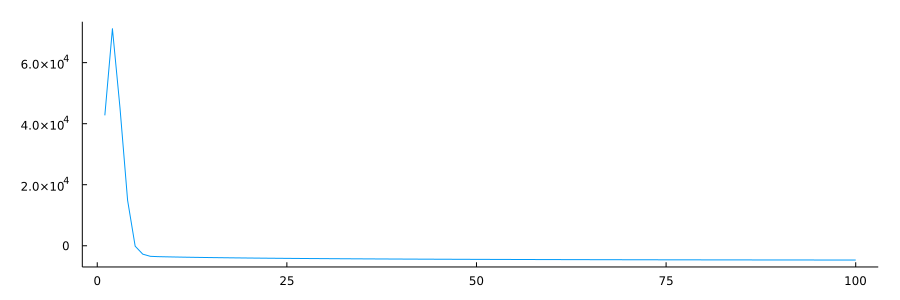

In [483]:
plot(fe)

In [484]:
# note y_out != yuh_, yuh_ is output of AR solely
y_out_ = yuh_;

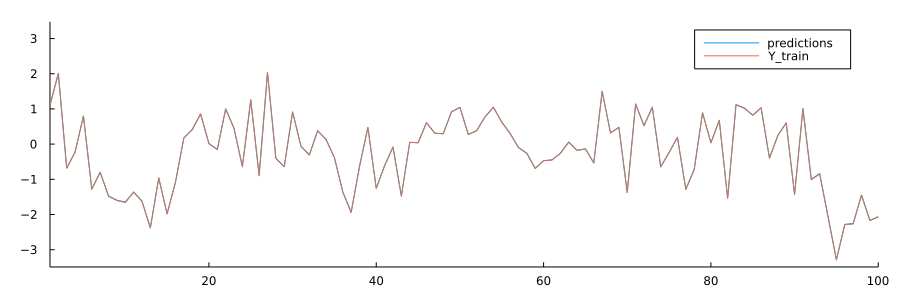

In [485]:
mfrom, mto = 1, 100
plot(first.(mean.(y_out_)), ribbon=first.(sqrt.(cov.(y_out_))), label="predictions")
plot!(Y_train, xlims=(mfrom, mto), label="Y_train")

In [486]:
mean(w)

9811.772881931058

In [487]:
mean(τ)

117.22961624593243

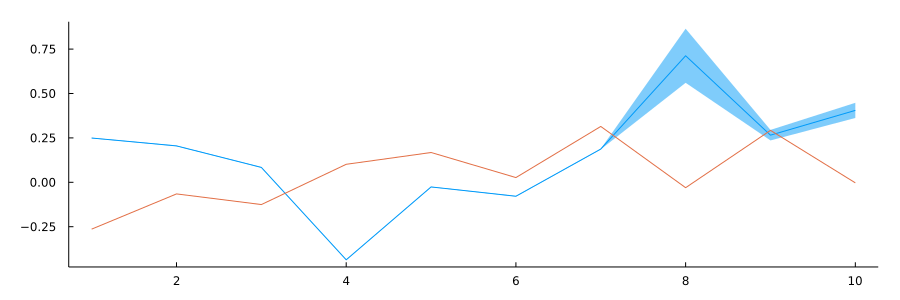

In [488]:
plot(mean(η), ribbon=diag(std(η)), label=false)
plot!(η_true, label=false)

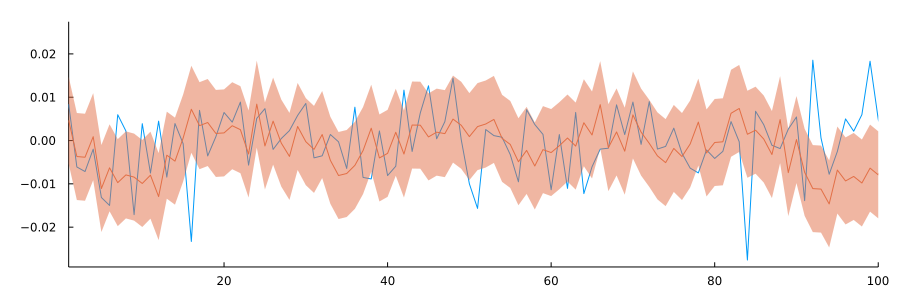

In [489]:
plot(syn_noise)
plot!(mean.(e), ribbon=sqrt.(cov.(e)), xlims=(1, 100))

## Prediction

In [490]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order)
    h_out = MvNormalMeanPrecision(mean(h_prior), precision(h_prior))
    Ys = Y*y_prev
    Us = U*u
    h_ = @call_rule typeof(*)(:out, Marginalisation) (m_A=PointMass(H), m_in=h_out)
    uh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Us), m_in2=h_)
    yuh = @call_rule typeof(+)(:out, Marginalisation) (m_in1=PointMass(Ys), m_in2=uh)
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=yuh, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())

    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ=PointMass(0.0), m_τ=PointMass(w_mle))
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=e_out)
end

prediction (generic function with 1 method)

In [491]:
predictions = []
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

ProgressMeter.@showprogress for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_prior), η_prior, τ_prior, X_test[i], U_test[i], full_order=full_order)
    push!(predictions, pred)
#     τ_post, w_post, h_post, e_post, η_post, yuh_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [Y_test[i]], [X_test[i]], [U_test[i]], delay_y, delay_u, delay_e)
#     h_prior = h_post
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
end

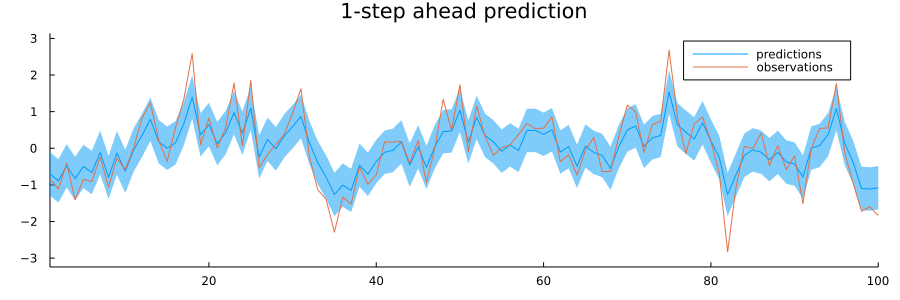

In [492]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(1, 100), title="1-step ahead prediction", label="observations")

In [493]:
RMSE = sqrt(mean((mean.(predictions) .- Y_test) .^2))

0.4241151424969324

In [430]:
h_prior = h[end].data
w_prior = w.data
τ_prior = τ.data
η_prior = η.data

simulated_X = [X_test[1]]
simulated_Y = [Y_test[1]]
simulated_Y_cov = [0.0]
simulated_error = Vector{Any}([h[end]])

ProgressMeter.@showprogress for i in 1:length(Y_test)
#     θ_post, w_post, h_post, η_post, τ_post = inference_callback(h_prior, η_prior, τ_prior, w_prior, [simulated_Y[i]], [simulated_X[i]], [U_test[i]], delay_y, delay_u, delay_e)
    
#     h_prior = h_post
#     η_prior = η_post
#     τ_prior = τ_post
#     w_prior = w_post
    
    push!(simulated_X, [simulated_Y[i]; simulated_X[i][1:delay_y-1]])
    
    pred_sim = prediction(h_prior, mean(w_prior), η_prior, τ_prior, simulated_X[end], U_test[i], full_order=full_order)

    push!(simulated_Y, mean(pred_sim))
    push!(simulated_Y_cov, var(pred_sim))
    push!(simulated_error, h_prior)
    

end

In [434]:
zoom = 1:100
RMSE = sqrt(mean((simulated_Y[zoom .+ 1] .- Y_test[zoom]).^2))

0.5388077700634011

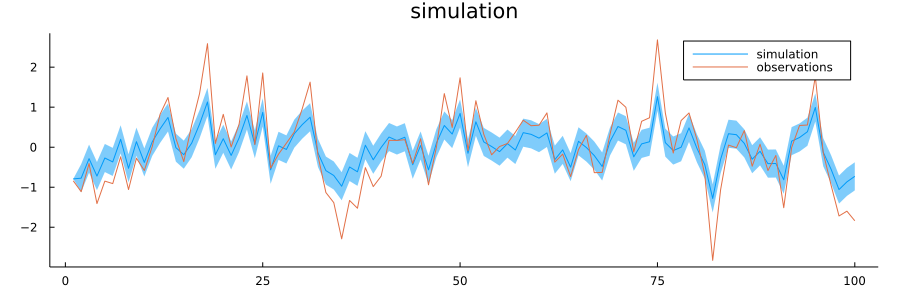

In [435]:
plot(simulated_Y[zoom.+1],  ribbon=simulated_Y_cov[zoom], label="simulation")
# plot!(first.(U_test[zoom]), label="controls")
plot!(Y_test[zoom], title="simulation", label="observations")